In [10]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Auto Regression
**自回归**(Auto Regression)模型是处理平稳时间序列数据的一种方法。假设某一随时间变化的数据$X$可以看成是跟之前的取值有关，那么$t$时刻的取值可以写成：
$$
x_{t}={\theta}x_{t-1}+\epsilon_{t}
$$
其中随机噪声$\epsilon_{t}{\sim}N(0,\sigma^{2})$。

<Figure size 432x288 with 0 Axes>

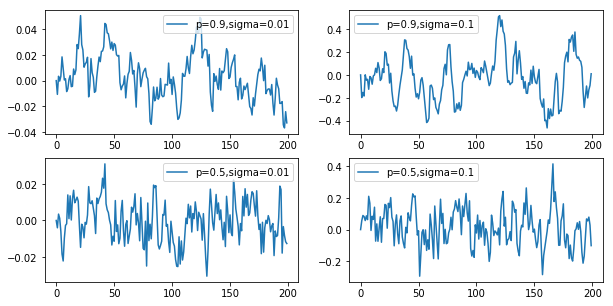

In [156]:
def gen_time_series(p,sigma):
    exp_1=[0]*200
    for i in range(1,200):
        exp_1[i]=p*exp_1[i-1]+random.normalvariate(0,sigma)
    return exp_1
    
plt.clf()
figs,axs=plt.subplots(2,2,figsize=(10,5))
axs[0][0].plot(gen_time_series(0.9,0.01))
axs[0][0].legend(['p=0.9,sigma=0.01'])
axs[0][1].plot(gen_time_series(0.9,0.1))
axs[0][1].legend(['p=0.9,sigma=0.1'])
axs[1][0].plot(gen_time_series(0.5,0.01))
axs[1][0].legend(['p=0.5,sigma=0.01'])
axs[1][1].plot(gen_time_series(0.5,0.1))
axs[1][1].legend(['p=0.5,sigma=0.1'])
plt.show()

不难看出参数$p$决定了数据随时间的衰减或增长，而$\sigma$决定了随机噪声对数据变化的扰动。定义一个$p$阶的**自回归**(auto regression)模型$AR(p)$：
$$
\begin{cases}
x_{t}={\theta}_{0}+{\theta}_{1}x_{t-1}+...+{\theta}_{p}x_{t-p}+\epsilon_{t} \\
{\theta}_{p}{\ne}0 \\
\epsilon_{t}{\sim}N(0,1) \\
E(x_{s}\epsilon_{t})=0, \quad {\forall}s<t \\
\end{cases}
$$
以下三个限制条件分别为：(1)p阶AR模型；(2)随机噪声服从高斯分布；(3)随机噪声与历史数据无关。

在AR模型的建模之前，我们首先需要确定手头的时间序列数据是否是平稳的非白噪声，用以判断该数据是否适用于AR模型。
![](img\bZkbWWG.jpg)

以下使用一个真实数据集来举例。

In [7]:
sentiment = pd.read_csv('data/sentiment.csv', index_col=0, parse_dates=[0])    # 第一列用作index
sentiment.sample(5)

,UMCSENT
DATE,
2003-01-01,82.4
2001-11-01,83.9
2014-01-01,81.2
2009-10-01,70.6
2015-05-01,90.7


## 白噪声检验
首先检验数据是否是白噪声序列，即序列的各数据是完全不相关的。我们可以做一个统计假设检验来测试某一时刻的数据是否与之前的某一数据相关。这里介绍一下**自相关函数(Autocorrelation Function)**ACF，他是用于计算时间序列自身相关性的。

In [14]:
from scipy import stats
import statsmodels.api as sm

lag = 10    # 往前推的时间数
data = sentiment.loc[:, 'UMCSENT']

acf, q, p = sm.tsa.acf(data, nlags=lag, qstat=True)  # 计算自相关系数 及p-value

out = np.c_[range(1, 1+lag), acf[1:], q, p]
output = pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.926404,173.374280,1.355912e-39
2.0,0.856144,322.199416,1.084641e-70
3.0,0.808030,455.443414,2.156885e-98
4.0,0.773742,578.245663,7.909183e-124
5.0,0.741185,691.511877,3.361281e-147
6.0,0.715215,797.526414,5.271303e-169
7.0,0.675550,892.600616,1.901800e-188
8.0,0.641754,978.849394,5.484360e-206
9.0,0.601715,1055.070798,2.287753e-221


可以看到该时间序列数据与之前几天的相关性还是很大的，若取显著性水平为0.05，计算得到的p-value都要小于0.05，所以可以认定该时间序列不是白噪声。

## 平稳化
对于非平稳数据，**差分**是一种有效的平稳化手段，即在序列中计算$x_{t+1}-x_{t}$生成一个新序列。

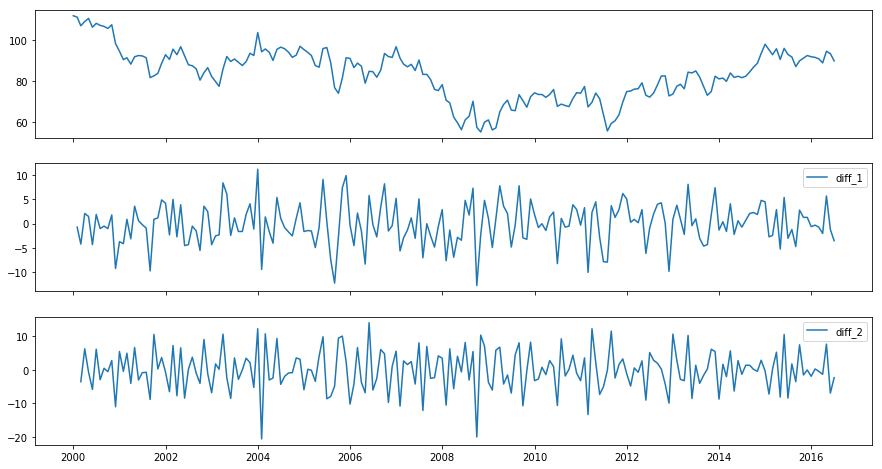

In [19]:
sentiment.loc[:,'diff_1']=sentiment.loc[:,'UMCSENT'].diff(1)    # 一阶差分
sentiment.loc[:,'diff_2']=sentiment.loc[:,'diff_1'].diff(1)    # 二阶差分

fig,axs=plt.subplots(3,1,figsize=(15,8),sharex=True)
axs[0].plot(sentiment.loc[:,'UMCSENT'])
axs[1].plot(sentiment.loc[:,'diff_1'])
axs[1].legend(['diff_1'])
axs[2].plot(sentiment.loc[:,'diff_2'])
axs[2].legend(['diff_2'])
plt.show()

**稳定性判断**。首先假设序列是弱平稳的，有：
$$
E(x_{t})=\mu \quad Var(x_{t})=\gamma_{0} \quad Cov(x_{t},x_{t-l})=\gamma_{l}
$$
，其中$\mu$、$\gamma_{0}$为常数。随机噪声满足：
$$
E(\epsilon_{t})=0 \quad Var(\epsilon_{t})=\sigma_{t}^{2}
$$
可以写出：
$$
\begin{align}
E(x_{t})&=\theta_{0}+\theta_{1}E(x_{t-1})+...+\theta_{p}E(x_{t-p}) \\
\mu&=\theta_{0}+\theta_{1}\mu+...+\theta_{p}\mu \\
E(x_{t})&=\mu=\frac{\theta_{0}}{1-\theta_{1}-...-\theta_{p}} \\
\end{align}
$$
注意其中的$\theta$参数是必须要先使用AR模型去拟合数据才能得到的。假设分母不为0，得到一个特征方程：
$$
1-\theta_{1}x-...-\theta_{p}x^{p}=0
$$
该方程的解的倒数称为特征根，如果所有特征根的模都小于1，则说明该时间序列是稳定的。

c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


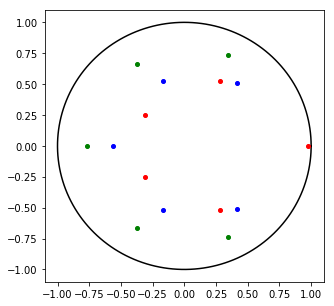

In [68]:
# 这里使用了ARMA函数，令q=0，可以获得等价AR的模型
model_org = sm.tsa.ARMA(sentiment.loc[:, 'UMCSENT'], (5, 0))
model_diff1 = sm.tsa.ARMA(sentiment.loc[:, 'diff_1'].dropna(), (5, 0))
model_diff2 = sm.tsa.ARMA(sentiment.loc[:, 'diff_2'].dropna(), (5, 0))

AR_org = model_org.fit()
AR_diff1 = model_diff1.fit()
AR_diff2 = model_diff2.fit()

r1 = 1
theta = np.linspace(0, 2*np.pi, 360)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)
plt.figure(figsize=(5, 5))
plt.plot(x1, y1, 'k')  # 画单位圆

roots_org = 1/AR_org.arroots  # 注意，这里results_ARMA.arroots 是特征方程的解，特征根取倒数
roots_diff1 = 1/AR_diff1.arroots
roots_diff2 = 1/AR_diff2.arroots

for i in range(len(roots_org)):
    plt.plot(roots_org[i].real, roots_org[i].imag, '.r', markersize=8)  # 画特征根
for i in range(len(roots_diff1)):
    plt.plot(roots_diff1[i].real, roots_diff1[i].imag, '.b', markersize=8)
for i in range(len(roots_diff2)):
    plt.plot(roots_diff2[i].real, roots_diff2[i].imag, '.g', markersize=8)

plt.show()

可以看到所有的特征根都小于1，说明不管是原始序列还是差分后的序列，都是稳定的。

除此之外，还可以通过$AR$模型的参数判断序列的稳定性。若$AR(p)$模型中的$\theta$均小于1，则序列是稳定的；否则是不稳定的。原因就在于参数$\theta$改变了时间序列$X_{t}$的期望值。

<Figure size 432x288 with 0 Axes>

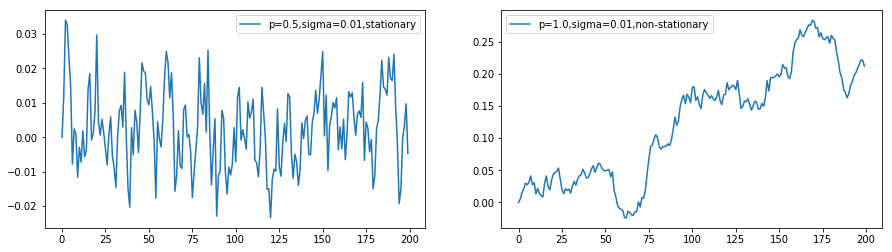

In [165]:
def gen_time_series(p,sigma):
    exp_1=[0]*200
    for i in range(1,200):
        exp_1[i]=p*exp_1[i-1]+random.normalvariate(0,sigma)
    return exp_1
    
plt.clf()
figs,axs=plt.subplots(1,2,figsize=(15,4))
axs[0].plot(gen_time_series(0.5,0.01))
axs[0].legend(['p=0.5,sigma=0.01,stationary'],loc='best')
axs[1].plot(gen_time_series(1,0.01))
axs[1].legend(['p=1.0,sigma=0.01,non-stationary'],loc='best')
plt.show()

## AR模型的参数确定
$AR(p)$模型唯一的参数就是阶数$p$(往前回滚的时间数)，如何确定该参数。有两个标准，一是根据**偏自相关函数**(Partial Auto Correlation Function)，二是根据**信息标准**(Information Criterion)。

<Figure size 432x288 with 0 Axes>

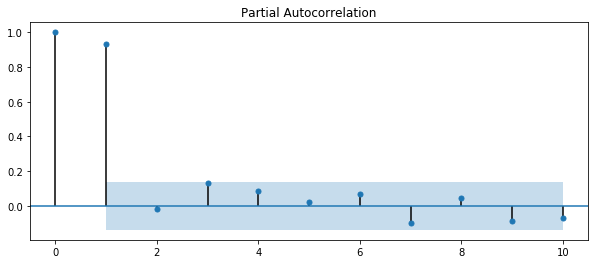

In [150]:
plt.clf()
fig,axs=plt.subplots(1,1,figsize=(10,4))
sm.graphics.tsa.plot_pacf(sentiment.loc[:,'UMCSENT'],ax=axs,lags=10,alpha=0.05)
plt.show()

从PACF绘图可以看出，在$p{\ge}2$时差不多就收敛到置信区间内了，这说明阶数$p$取$2$就可以了。

接下来介绍另一种标准IC，statsmodel中内置的IC有三种：
$$
\begin{align}
AIC&=2k-2{\ln}(\hat{L}) \\
BIC&=k{\ln}(n)-2{\ln}(\hat{L}) \\
HQIC&=2k{\ln}({\ln}(n))-2{\ln}(\hat{L}) \\
\end{align}
$$
其中$k$为模型的参数数量，$\hat{L}$是最大似然函数值，$n$是样本数量。我们选取使得ID最小化的参数$p$。


c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different res

<Figure size 432x288 with 0 Axes>

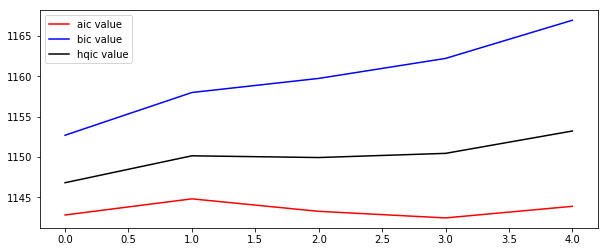

In [70]:
aicList = []
bicList = []
hqicList = []
for i in range(1,6):  #从1阶开始算
    order = (i,0)
    ARmodel = sm.tsa.ARMA(sentiment.loc[:, 'UMCSENT'],order).fit()
    aicList.append(ARmodel.aic)
    bicList.append(ARmodel.bic)
    hqicList.append(ARmodel.hqic)

plt.clf()
plt.figure(figsize=(10,4))
plt.plot(aicList,'r',label='aic value')
plt.plot(bicList,'b',label='bic value')
plt.plot(hqicList,'k',label='hqic value')
plt.legend(loc='best')

## 结果检验

c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different res

<Figure size 432x288 with 0 Axes>

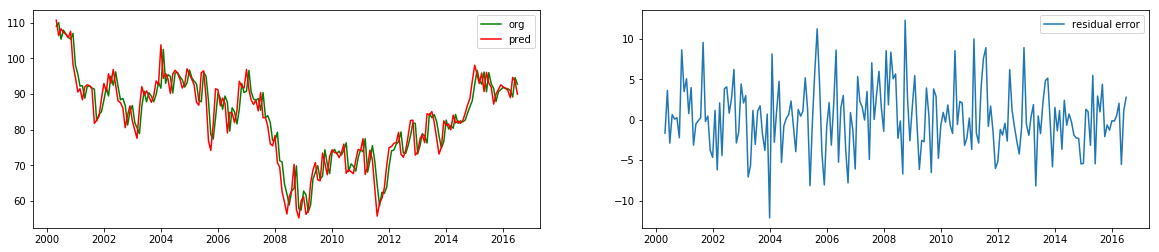

In [114]:
p=4
model_org = sm.tsa.ARMA(sentiment.loc[:, 'UMCSENT'], (p, 0))
AR_org = model_org.fit()
residual_err=AR_org.fittedvalues[p:]-sentiment.loc[:, 'UMCSENT'][p:]

plt.clf()
fig,axs=plt.subplots(1,2,figsize=(20,4))
axs[0].plot(AR_org.fittedvalues[p:],'g',label='org')
axs[0].plot(sentiment.loc[:, 'UMCSENT'][p:],'r',label='pred')
axs[0].legend()
axs[1].plot(residual_err,label='residual error')
axs[1].legend()
plt.show()

这里需要额外提一点的是，一个充分拟合的模型，其预测值与真实值的残差应该是完全随机的，也就是说完美模型的残差应该是一个随机噪声，因为真实数据中就包含了无法预测的随机噪声。这对于任何机器学习任务都是成立的，在时间序列的场景下更是如此。所以这里需要检验AR模型的残差是否具有自相关性。

In [103]:
lag=10
acf,q,p = sm.tsa.acf(residual_err,nlags=lag,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,lag+1), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,-0.021078,0.087971,0.766773
2.0,-0.024623,0.208645,0.900935
3.0,-0.021621,0.302177,0.959619
4.0,-0.058130,0.981805,0.912542
5.0,-0.060301,1.716995,0.886752
6.0,0.097816,3.661717,0.722344
7.0,-0.050312,4.178959,0.758950
8.0,0.073472,5.287894,0.726409
9.0,0.067728,6.235286,0.716158


取显著性因子为0.05，所有的p-value值都大于0.05，所以不能拒绝空假设，即残差不具有自相关性，可以认为是随机噪声。

## 模型评估
类似于传统的机器学习任务，时间序列预测同样需要一个评测指标来表征模型的优劣。当然，常用的MSE是可用的，这里使用$R^{2}$值来做评估。

In [116]:
score = 1 - residual_err.var()/sentiment.loc[:, 'UMCSENT'][p:].var()
print(score)

0.8785811382781129


可以看到效果还算不赖，下面我们做一下真实的预测，先把数据集划分成训练集与测试集，在训练集上训练模型，再预测测试集。

In [117]:
len(sentiment.loc[:, 'UMCSENT'])

199

In [133]:
# train_set=sentiment.loc[:, 'UMCSENT'][:-20]
# test_set=sentiment.loc[:, 'UMCSENT'][-20:]

p=4
AR_model=sm.tsa.ARMA(sentiment.loc[:, 'UMCSENT'][:190], order=(p, 0))
AR_res=AR_model.fit()
pred=AR_res.predict(190,198,dynamic = True)

comp = pd.DataFrame()
comp['ture'] = sentiment.loc[:, 'UMCSENT'][190:]
comp['pred'] = pred
comp

c:\users\qq435\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,ture,pred
DATE,,
2015-11-01,91.3,90.623500
2015-12-01,92.6,90.675841
2016-01-01,92.0,90.150582
2016-02-01,91.7,89.997776
2016-03-01,91.0,89.986688
2016-04-01,89.0,89.989511
2016-05-01,94.7,89.928253
2016-06-01,93.5,89.852392
2016-07-01,90.0,89.786878


# Moving Average
**移动平均**(Moving Average)模型是处理稳定时间序列数据的另一种方法，假设某一时间序列数据只跟历史噪声有关，那么$t$时刻的取值可以写成：
$$
x_{t}=\mu+\epsilon_{t}-{\phi}\epsilon_{t-1}
$$
其中$\mu$是时间序列$X_{t}$的期望值，$\epsilon$为随机噪声。

<Figure size 432x288 with 0 Axes>

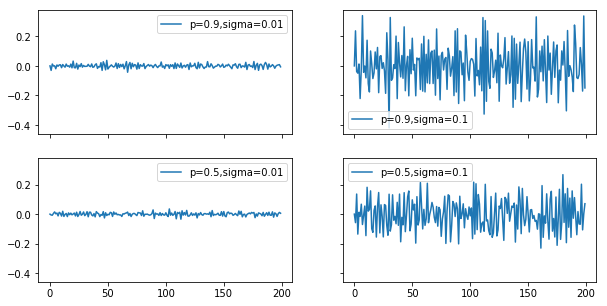

In [154]:
def gen_time_series(q,sigma):
    eps=[random.normalvariate(0,sigma) for _ in range(200)]    # 时间噪声序列
    x_t=[0]*200
    for i in range(1,200):
        x_t[i]=eps[i]-q*eps[i-1]    # 当前噪声+加权历史噪声
    return x_t

plt.clf()
figs,axs=plt.subplots(2,2,figsize=(10,5),sharex=True,sharey=True)
axs[0][0].plot(gen_time_series(0.9,0.01))
axs[0][0].legend(['p=0.9,sigma=0.01'])
axs[0][1].plot(gen_time_series(0.9,0.1))
axs[0][1].legend(['p=0.9,sigma=0.1'])
axs[1][0].plot(gen_time_series(0.5,0.01))
axs[1][0].legend(['p=0.5,sigma=0.01'])
axs[1][1].plot(gen_time_series(0.5,0.1))
axs[1][1].legend(['p=0.5,sigma=0.1'])
plt.show()

不难写出$q$阶的$MA(q)$:
$$
\begin{cases}
x_{t}=\mu+\epsilon_{t}-\phi_{1}\epsilon_{t-1}-...-\phi_{q}\epsilon_{t-q} \\
\phi_{q}{\ne}0 \\
\epsilon_{t}{\sim}N(0,\sigma^{2}) \\
E(\epsilon_{s}\epsilon_{t})=0, \quad {\forall}s<t \\
\end{cases}
$$
前文提到AR序列的PACF是截尾的，与之相反，MA序列的ACF是截尾的。PACF可用于AR模型的定阶，而ACF可用于MA模型的定阶。

<Figure size 432x288 with 0 Axes>

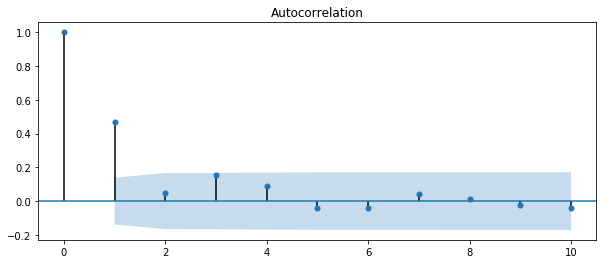

In [152]:
plt.clf()
fig,axs=plt.subplots(1,1,figsize=(10,4))
sm.graphics.tsa.plot_acf(gen_time_series(0.9,0.1),ax=axs,lags=10,alpha=0.05)
plt.show()

# ARMA
在已有AR与MA的基础上，不难得出$ARMA(p,q)$的模型表达式：
$$
x_{t}=\theta_{0}+\theta_{1}x_{t-1}+...+\theta_{p}x_{t-p}+\epsilon_{t}+\phi_{1}\epsilon_{t-1}+...+\phi_{q}\epsilon_{t-q}
$$